#Introduction

Sensitivity related calculations including sensitivity limits and data simulation.  Developed for the Australian Space Eye but much of this should have general applicability.

## Code preamble

In [1]:
from __future__ import division,unicode_literals # Half arsed attempt at Python 2 compatibility

In [2]:
%matplotlib inline

In [3]:
import numpy as np
from scipy.interpolate import RectSphereBivariateSpline, SmoothBivariateSpline, InterpolatedUnivariateSpline
from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
from astropy.io import fits
from astropy.table import Table
from astropy import units as u
from astropy.constants import h,c
import healpy as hp

In [4]:
rcParams['figure.figsize'] = 12, 9

# Instrument efficiency & light gathering power

End-to-end throughput of the instrument from the entrance aperture through to photo-electrons in the image sensor

##  Entrance pupil area

* Cubesat format effectively limits us to a maximum aperture diameter of 90 mm
* To avoid diffraction spike we want to a circular pupil
* Pupil will be unobscured

In [5]:
pupil_area = (np.pi * (90 * u.mm)**2 / 4).si
pupil_area

<Quantity 0.0063617251235193305 m2>

## Throughput of optics

* With appropriate glasses there will be negligible bulk absorption in the visible wavelength range
* With anti-reflection coatings optimised for a specific band can expect at least 0.995 transmission at each surface throughout each band
* Baseline design is 5 elements in 5 groups, i.e. 10 vacuum-glass interfaces
* Last surface accounted for in next section

In [6]:
n_surfaces = 9 # Doesn't include last surface
throughput = 0.995**n_surfaces * u.dimensionless_unscaled
throughput

<Quantity 0.9558895783575596>

## Filters

* Huntsman project as a whole will use SDSS filters
* Baseline design has the filter implemented as the coating on the last optical surface before the detector
* There are many subtly different implementations, we will copy DECam filters as filter transmission data is readily available, e.g. http://svo2.cab.inta-csic.es/theory/fps/index.php?&mode=browse&gname=CTIO&gname2=DECam

In [7]:
# Load DECam filter data
filters = [Table.read('http://svo2.cab.inta-csic.es/theory/fps/fps.php?ID=CTIO/DECam.u'), \
           Table.read('http://svo2.cab.inta-csic.es/theory/fps/fps.php?ID=CTIO/DECam.g'), \
           Table.read('http://svo2.cab.inta-csic.es/theory/fps/fps.php?ID=CTIO/DECam.r'), \
           Table.read('http://svo2.cab.inta-csic.es/theory/fps/fps.php?ID=CTIO/DECam.i'), \
           Table.read('http://svo2.cab.inta-csic.es/theory/fps/fps.php?ID=CTIO/DECam.z')]

for f in filters:
    # Set units correctly
    f['Wavelength'] = f['Wavelength'].to(u.um)
    f['Wavelength'].unit = u.um
    f['Transmission'].unit = u.dimensionless_unscaled

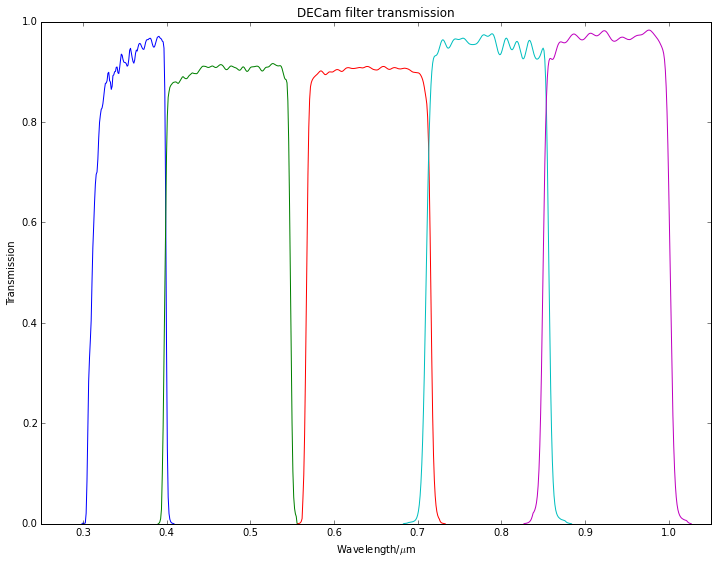

In [8]:
for f in filters:
    plt.plot(f['Wavelength'], f['Transmission'])
    plt.xlim(0.25,1.05)
    plt.xlabel('Wavelength/$\mu$m')
    plt.ylabel('Transmission')
    plt.title('DECam filter transmission')

##Image sensor

Baseline concept uses an e2V CIS115, a 2000 x 1504 pixel back-illuminated monolithic CMOS image sensor with 7 micron pixel pitch.  Numerical QE data is hard to come by but there are some plots available from which we can extract approximate date with http://arohatgi.info/WebPlotDigitizer/, the most useful of which appears to be in Soman et al (2014), http://proceedings.spiedigitallibrary.org/proceeding.aspx?articleid=1891353, which has full wavelength range predicted QE at both +20$^\circ$C and -40$^\circ$C.  These data seem quite conservative as Wang et al (2014), http://proceedings.spiedigitallibrary.org/proceeding.aspx?articleid=1891414, get higher peak QE from both e2v's and their own measurements on a prototype device.

<img src="resources/cis115qe.png" width=800px />

In [11]:
qe_p20C = Table.read('resources/cis115_QE_20C.csv')
qe_m40C = Table.read('resources/cis115_QE_-40C.csv')

qe_p20C['Wavelength'].unit = u.um
qe_m40C['Wavelength'].unit = u.um

qe_p20C['QE'].unit = u.electron / u.photon
qe_m40C['QE'].unit = u.electron / u.photon

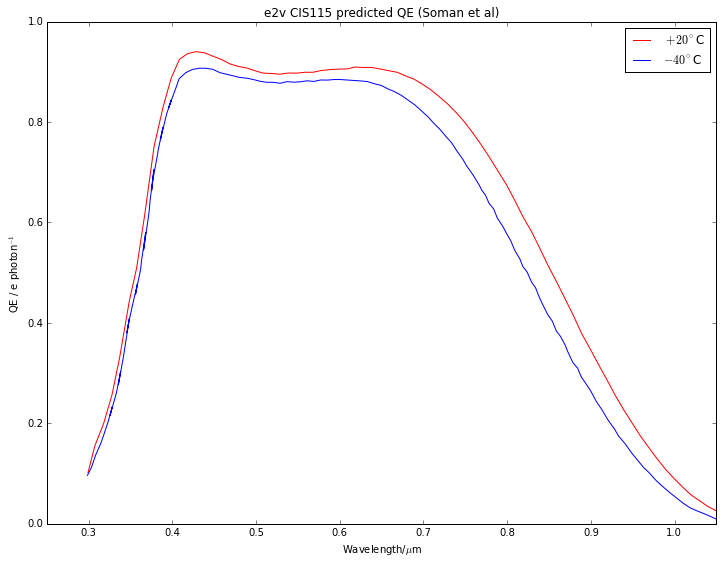

In [12]:
plt.plot(qe_p20C['Wavelength'], qe_p20C['QE'], 'r-', label='$+20^\circ$C')
plt.plot(qe_m40C['Wavelength'], qe_m40C['QE'], 'b-', label='$-40^\circ$C')
plt.xlim(0.25,1.05)
plt.ylim(0,1)
plt.xlabel('Wavelength/$\mu$m')
plt.ylabel('QE / e photon$^{-1}$')
plt.legend(loc='best')
plt.title('e2v CIS115 predicted QE (Soman et al)')
plt.savefig('QE.png')

### End-to-end efficiency

Combine throughput of optics, filters and image sensor QE (at nominal operating temperature of -40$^\circ$C).

In [13]:
efficiencies = []

for f in filters:
    # Interpolate QE data at same wavelengths as filter transmission data
    i = np.interp(f['Wavelength'], qe_m40C['Wavelength'], qe_m40C['QE']) *  qe_m40C['QE'].unit
    efficiencies.append(throughput * f['Transmission'].quantity * i)

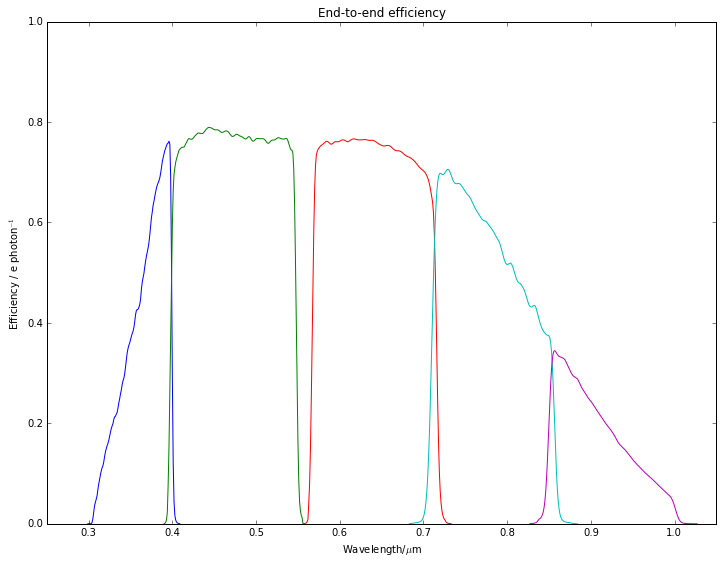

In [14]:
for i, f in enumerate(filters):
    plt.plot(f['Wavelength'], efficiencies[i])
    plt.xlim(0.25,1.05)
    plt.ylim(0,1)
    plt.xlabel('Wavelength/$\mu$m')
    plt.ylabel('Efficiency / e photon$^{-1}$')
    plt.title('End-to-end efficiency')
    plt.savefig('eff.png')

## Effective aperture area

Can calculate an effective aperture area as the aperture area multiplied by the end-to-end efficiency 

In [15]:
eff_areas = [pupil_area * efficiency for efficiency in efficiencies]

## Effective étendue

Similarly can calculate an effective étendue ($A\Omega$) per pixel by multiplying the effective aperture area by the solid angle subtended by each pixel.  In the baseline design each pixel is 3 arcseconds across.

In [16]:
eff_etendues = [eff_area * (3 * u.arcsecond)**2 / u.pixel for eff_area in eff_areas]

# Sky background

## Zodical light

In space the visible wavelength sky background is dominated by zodiacal light.  To model the zodiacal light we follow the same prescription as the HST ETC, as described in Giavilisco, Saul & Bohlin (2002), http://www.stsci.edu/hst/wfc3/documents/ISRs/2002/WFC3-2002-12.pdf.

### Solar spectrum

In the visible wavelength range the zodiacal light is the result of scattered sunlight.  Consequently the starting point is a solar spectrum from Colina, Bohlin & Castelli (1996), http://adslabs.org/adsabs/abs/1996AJ....112..307C/

In [17]:
sun = fits.open('resources/sun_castelli.fits')

In [18]:
sun.info()

Filename: resources/sun_castelli.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU      14   ()              
1                BinTableHDU     16   22999R x 2C   [1E, 1E]   


In [19]:
sun[0].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format defined in Astronomy and
COMMENT   Astrophysics Supplement Series v44/p363, v44/p371, v73/p359, v73/p365.
COMMENT   Contact the NASA Science Office of Standards and Technology for the   
COMMENT   FITS Definition document #100 and other FITS information.             
ORIGIN  = 'STScI-STSDAS/TABLES' / Tables version 1999-03-22                     
FILENAME= 'sun_castelli.fits'  / name of file                                   
HISTORY   Created Thu 15:49:31 16-Nov-95                                        
COMMENT   solar model spectrum calculated by F. Castelli.                       
COMMENT   Absolute flux norm

In [20]:
sun[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                    8 / width of table in bytes                        
NAXIS2  =                22999                                                  
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                    2                                                  
TTYPE1  = 'WAVELENGTH'         / label for field   1                            
TFORM1  = '1E      '           / data format of field: 4-byte REAL              
TUNIT1  = 'ANGSTROMS'          / physical unit of field                         
TTYPE2  = 'FLUX    '           / label for field   2                            
TFORM2  = '1E      '        

In [21]:
sun_waves = sun[1].data['WAVELENGTH'] * u.Angstrom 

In [22]:
sun_flux = sun[1].data['FLUX'] * u.erg * u.second**-1 * u.cm**-2 * u.Angstrom**-1

###Normalisation & reddening

To convert the solar spectrum to a zodical light spectrum it is normalised and reddened following the prescription of Leinert et al (1997), http://www.edpsciences.org/10.1051/aas:1998105, with the revised parameters from Aldering (2001), http://www-supernova.lbl.gov/~aldering/zodi.pdf.  The result is normalised to the correct surface brightness for the north ecliptic pole (NEP).

In [23]:
# Colina, Bohlin & Castelli solar spectrum normalised to V band flux 
# of 184.2 ergs/s/cm^2/A,
solar_normalisation = 184.2 * u.erg * u.second**-1 * u.cm**-2 * u.Angstrom**-1
# Leinert at al NEP zodical light 1.81e-18 erg/s/cm^2/A/arcsec^2 at 0.5 um, 
# Aldering suggests using 0.01 dex lower.
zl_nep = 1.81e-18 * u.erg * u.second**-1 * u.cm**-2 * u.Angstrom**-1 * \
    u.arcsecond**-2 * 10**(-0.01)

zl_normalisation = zl_nep / solar_normalisation

lambda_c = 0.5 * u.micron

# Aldering reddening parameters
f_blue = 0.9
f_red = 0.48

def solar_to_ZL(waves):
    """
    Calculate factors to convert a Colina et alsolar spectrum to spectrum
    for the zodical light normalised for NEP.  Follows the prescription of 
    Leinert et al (1997) with the revised parameters from Aldering (2001) 
    as used in the HST ETC (Giavalsico, Sahi & Bohlin (2002)).
    """
    rfactor = np.where(waves < lambda_c, \
                       1.0 + f_blue * np.log(waves/lambda_c), \
                       1.0 + f_red * np.log(waves/lambda_c))
    return zl_normalisation * rfactor

In [24]:
zl_waves = sun_waves.to(u.micron)
zl_flux = (sun_flux * solar_to_ZL(sun_waves))
zl_flux = zl_flux.to(u.Watt * u.m**-2 * u.arcsecond**-2 * u.micron**-1)

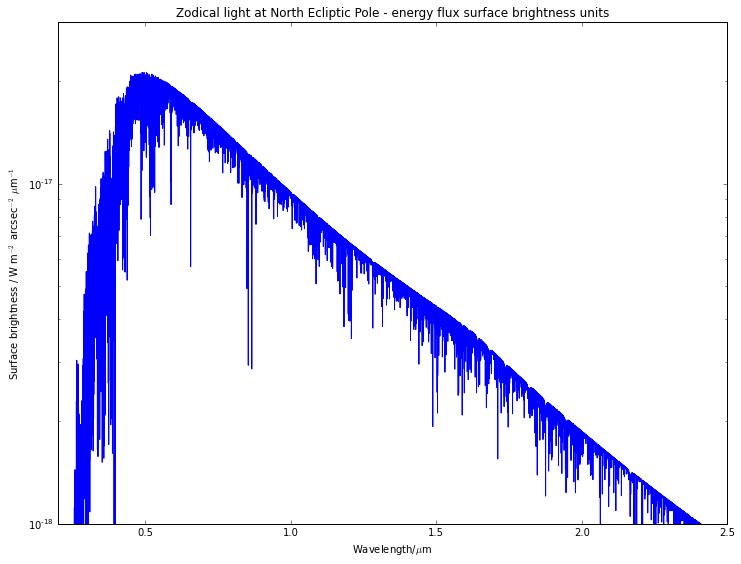

In [25]:
plt.semilogy(zl_waves, zl_flux)
plt.xlim(0.2,2.5)
plt.ylim(1e-18,3e-17)
plt.xlabel('Wavelength/$\mu$m')
plt.ylabel('Surface brightness / W m$^{-2}$ arcsec$^{-2}$ $\mu$m$^{-1}$')
plt.title('Zodical light at North Ecliptic Pole - energy flux surface brightness units');

###Conversion to photon flux surface brightness units

Divide by photon energies to convert to photon based units.

In [26]:
photon_energies = (h * c / sun_waves) / u.photon
zl_photons = zl_flux / photon_energies
zl_photons = zl_photons.to(u.photon * u.second**-1 * u.m**-2 * u.arcsecond**-2 *  u.micron**-1)

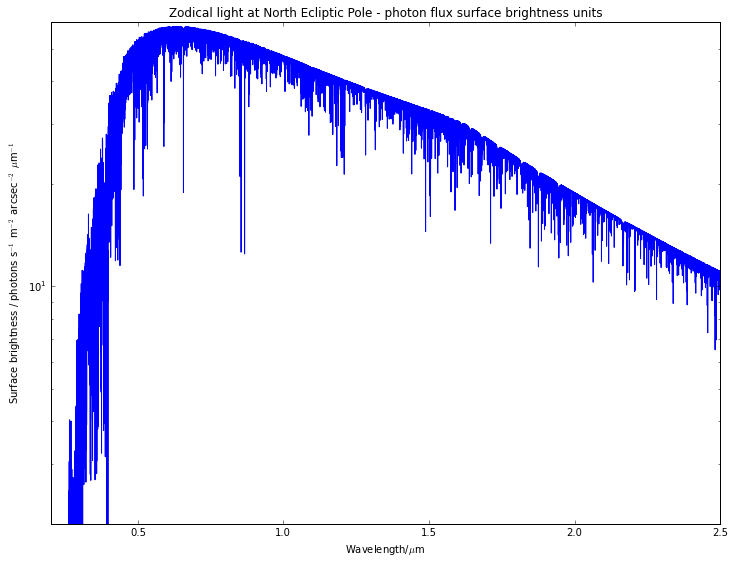

In [27]:
plt.semilogy(zl_waves, zl_photons, label='Zodical Light - NEP')
plt.xlim(0.2,2.5)
plt.ylim(2e-0,6e1)
plt.xlabel('Wavelength/$\mu$m')
plt.ylabel('Surface brightness / photons s$^{-1}$ m$^{-2}$ arcsec$^{-2}$ $\mu$m$^{-1}$')
plt.title('Zodical light at North Ecliptic Pole - photon flux surface brightness units');

### Detected background

To convert the sky background brightness to electrons per second per pixel in the image sensor we multiply the sky background by the effective étendues then integrate over the wavelength range of each band.

In [28]:
zl_ep = []
for i, f in enumerate(filters):
    # Interpolate etendue data at same wavelengths as zodiacal light data
    eff_etendue =  np.interp(zl_waves, f['Wavelength'], eff_etendues[i]) * \
        eff_etendues[i].unit
    # Multiply zodical light surface brightness by effective etendue
    zl_epw = zl_photons * eff_etendue
    # Integrate over wavelength
    zl_ep.append(np.trapz(zl_epw, x=zl_waves))
    
zl_ep = u.Quantity(zl_ep)
zl_ep

<Quantity [ 0.02944979, 0.26831068, 0.35355352, 0.25612122, 0.0827588 ] electron / (pix s)>

###Dependence on position

The zodiacal light background calculated so far is for the North Ecliptic Pole.  Tables 16 & 17 of Leinert et al (1997) present data showing how the average surface brightness varies with (ecliptic longitude - solar ecliptic longitude) and ecliptic latitude.  To allow evaluation of the zodiacal light surface brightness at arbitrary positions on the sky we will interpolate these tabular data and use it to scale the North Ecliptic Pole value. 

The zodical light is generally very smooth, effects such as resonant structures, comet tails and asteroid collisions result in variations of less than 1% which are largely confined to low ecliptic latitudes.  We will not consider these here.

Leinert et al also present evidence for variations in the degree of reddening with solar elongation however at visible wavelengths this effect will be small unless the telescope is pointed close to the Sun.  As positions close to the Sun would not be observed by ASE we will neglect this effect.

In [29]:
# Data from table 17, Leinert et al (1997).
llsun = np.array([0, 5 ,10, 15, 20, 25, 30, 35, 40, 45, 60, 75, 90, 105, 120, 135, 150, 165, 180])
beta = np.array([0, 5, 10, 15, 20, 25, 30, 45, 60, 75])
zl_scale = np.array([[np.NaN, np.NaN, np.NaN, 3140, 1610, 985, 640, 275, 150, 100], \
                     [np.NaN, np.NaN, np.NaN, 2940, 1540, 945, 625, 271, 150, 100], \
                     [np.NaN, np.NaN, 4740, 2470, 1370, 865, 590, 264, 148, 100], \
                     [11500, 6780, 3440, 1860, 1110, 755, 525, 251, 146, 100], \
                     [6400, 4480, 2410, 1410, 910, 635, 454, 237, 141, 99], \
                     [3840, 2830, 1730, 1100, 749, 545, 410, 223, 136, 97], \
                     [2480, 1870, 1220, 845, 615, 467, 365, 207, 131, 95], \
                     [1650, 1270, 910, 680, 510, 397, 320, 193, 125, 93], \
                     [1180, 940, 700, 530, 416, 338, 282, 179, 120, 92], \
                     [910, 730, 555, 442, 356, 292, 250, 166, 116, 90], \
                     [505, 442, 352, 292, 243, 209, 183, 134, 104, 86], \
                     [338, 317, 269, 227, 196, 172, 151, 116, 93, 82], \
                     [259, 251, 225, 193, 166, 147, 132, 104, 86, 79], \
                     [212, 210, 197, 170, 150, 133, 119, 96, 82, 77], \
                     [188, 186, 177, 154, 138, 125, 113, 90, 77, 74], \
                     [179, 178, 166, 147, 134, 122, 110, 90, 77, 73], \
                     [179, 178, 165, 148, 137, 127, 116, 96, 79, 72], \
                     [196, 192, 179, 165, 151, 141, 131, 104, 82, 72], \
                     [230, 212, 195, 178, 163, 148, 134, 105, 83, 72]]).transpose()

# Normalise to a value of 1.0 at the NEP
zl_scale /= 77

# Expand range of angles to cover the full sphere by using symmetry
beta = np.array(np.concatenate((-np.flipud(beta)[:-1], beta))) * u.degree
llsun = np.array(np.concatenate((llsun, 360 - np.flipud(llsun)[1:-1]))) * u.degree
zl_scale = np.concatenate((np.flipud(zl_scale)[:-1],zl_scale))
zl_scale = np.concatenate((zl_scale,np.fliplr(zl_scale)[:,1:-1]),axis=1)

# Convert angles to radians within the required ranges.
beta = beta.to(u.radian).value + np.pi/2
llsun = llsun.to(u.radian).value

The Scipy spherical interpolation functions can't handle the missing values for positions near to the Sun, 
either the interpolation fails to run or there are ringing artefacts.  To overcome this we use an 
initial cartesian interpolation pass on a subset of the data near to the sun in order to smoothly 
fill in the mising values, then use spherical interpolation on the full, filled in data set.

In [30]:
# For initial cartesian interpolation want the hole in the middle of the data,
# i.e. want to remap longitudes onto -180 to 180, not 0 to 360 degrees.
# Only want the region of closely spaced data point near to the Sun.
beta_c = beta[3:-3]
nl = len(llsun)
llsun_c = np.concatenate((llsun[nl//2+9:]-2*np.pi,llsun[:nl//2-8]))
zl_scale_c = np.concatenate((zl_scale[3:-3,nl//2+9:],zl_scale[3:-3,:nl//2-8]),axis=1)

# Convert everthing to 1D arrays (lists) of x, y and z coordinates.
llsuns, betas = np.meshgrid(llsun_c, beta_c)
llsuns_c = llsuns.ravel()
betas_c = betas.ravel()
zl_scale_cflat = zl_scale_c.ravel()

# Indices of the non-NaN points
good = np.where(np.isfinite(zl_scale_cflat))

# 2D cartesian interpolation function
zl_scale_c_interp = SmoothBivariateSpline(betas_c[good], llsuns_c[good], zl_scale_cflat[good])

# Calculate interpolated values
zl_scale_fill = zl_scale_c_interp(beta_c, llsun_c)

# Remap the interpolated values back to original ranges of coordinates
zl_patch = np.zeros(zl_scale.shape)
zl_patch[3:16,0:10] = zl_scale_fill[:,9:]
zl_patch[3:16,-9:] = zl_scale_fill[:,:9]

# Fill the hole in the original data with values from the cartesian interpolation
zl_patched = np.where(np.isfinite(zl_scale),zl_scale,zl_patch)

# Spherical interpolation function from the full, filled data set
zl_scale_interp = RectSphereBivariateSpline(beta, llsun, zl_patched, \
                                            pole_continuity=(False,False), pole_values=(1.0, 1.0), \
                                            pole_exact=True, pole_flat=False)

/home/ajh/Documents/virtualenvs/sci-latest-python3.4.1/lib/python3.4/site-packages/matplotlib/colors.py:994: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


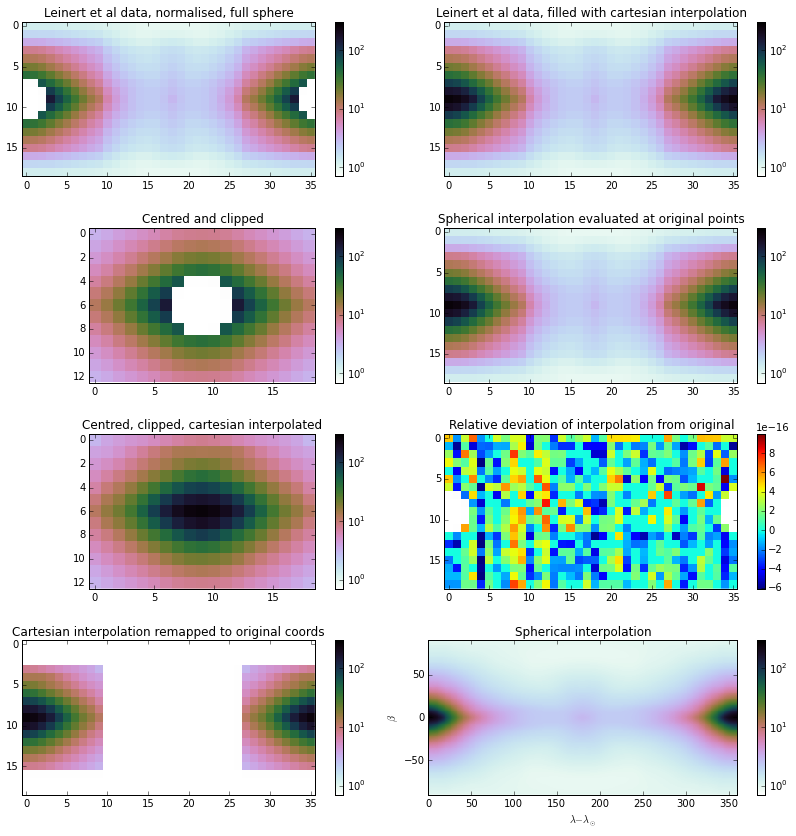

In [31]:
# Check the process with some plots
n_rows = 4
n_cols = 2

plt.subplot(n_rows,n_cols,1)
plt.imshow(zl_scale, norm=colors.LogNorm(vmin=0.7,vmax=300), \
           interpolation='none', cmap='cubehelix_r')
plt.colorbar()
plt.title('Leinert et al data, normalised, full sphere')

plt.subplot(n_rows,n_cols,3)
plt.imshow(zl_scale_c, norm=colors.LogNorm(vmin=0.7,vmax=300), interpolation='none', cmap='cubehelix_r')
plt.colorbar()
plt.title('Centred and clipped')

plt.subplot(n_rows,n_cols,5)
plt.imshow(zl_scale_fill, norm=colors.LogNorm(vmin=0.7,vmax=300), interpolation='none', cmap='cubehelix_r')
plt.colorbar()
plt.title('Centred, clipped, cartesian interpolated')

plt.subplot(n_rows,n_cols,7)
plt.imshow(zl_patch, norm=colors.LogNorm(vmin=0.7,vmax=300), interpolation='none', cmap='cubehelix_r')
plt.colorbar()
plt.title('Cartesian interpolation remapped to original coords')

plt.subplot(n_rows,n_cols,2)
plt.imshow(zl_patched, norm=colors.LogNorm(vmin=0.7,vmax=300), interpolation='none', cmap='cubehelix_r')
plt.colorbar()
plt.title('Leinert et al data, filled with cartesian interpolation')

plt.subplot(n_rows,n_cols,4)
plt.imshow(zl_scale_interp(beta, llsun), norm=colors.LogNorm(vmin=0.7,vmax=300), \
           interpolation='none', cmap='cubehelix_r')
plt.colorbar()
plt.title('Spherical interpolation evaluated at original points')

plt.subplot(n_rows,n_cols,6)
plt.imshow((zl_scale_interp(beta, llsun) - zl_scale)/zl_scale, interpolation='none',)
plt.colorbar()
plt.title('Relative deviation of interpolation from original')

plt.subplot(n_rows,n_cols,8)
plt.imshow(zl_scale_interp(np.linspace(0,np.pi,180),np.linspace(0,2*np.pi,360)), \
           origin='lower', extent=[0,360,-90,90], norm=colors.LogNorm(vmin=0.7,vmax=300), \
           interpolation='none', cmap='cubehelix_r')
plt.colorbar()
plt.title('Spherical interpolation')
plt.xlabel('$\lambda - \lambda_{\odot}$')
plt.ylabel('$\\beta$')

plt.tight_layout()
plt.gcf().set_size_inches(12,12)

We will precalculate an all-sky map of the zodical light surface brightness distribution using the HEALPix pixelation (http://healpix.sourceforge.net/).  We can use the `healpy` tools to extract projections of this map for signal to noise calculations.

**Want to calculate these in galactic coordinates for later combination with dust maps**

In [31]:
# Calculate all sky map
# *WARNING* This takes a long time, generally will just want to load it from zl_map.fits instead,
# see cell two below.
nside = 2048
zl_map=np.empty(hp.nside2npix(nside))
for i in range(zl_map.size):
    theta, phi = hp.pix2ang(nside, i)
    zl_map[i] = zl_scale_interp(theta, phi)

KeyboardInterrupt: 

In [32]:
# Write the zodiacal light map to file (it takes a long time to calculate, don't want to have to redo it all the time).
hp.write_map('resources/zl_map.fits', zl_map, fits_IDL=False, coord='E', column_names=('ZL_rel_SB',))

        Use :meth:`BinTableHDU.from_columns` for new BINARY tables or :meth:`TableHDU.from_columns` for new ASCII tables instead. [healpy.fitsfunc]
        Use :meth:`BinTableHDU.from_columns` for new BINARY tables or :meth:`TableHDU.from_columns` for new ASCII tables instead.


In [34]:
# Read zodical light map from file
zl_map = hp.read_map('resources/zl_map.fits')

NSIDE = 2048
ORDERING = RING in fits file


0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


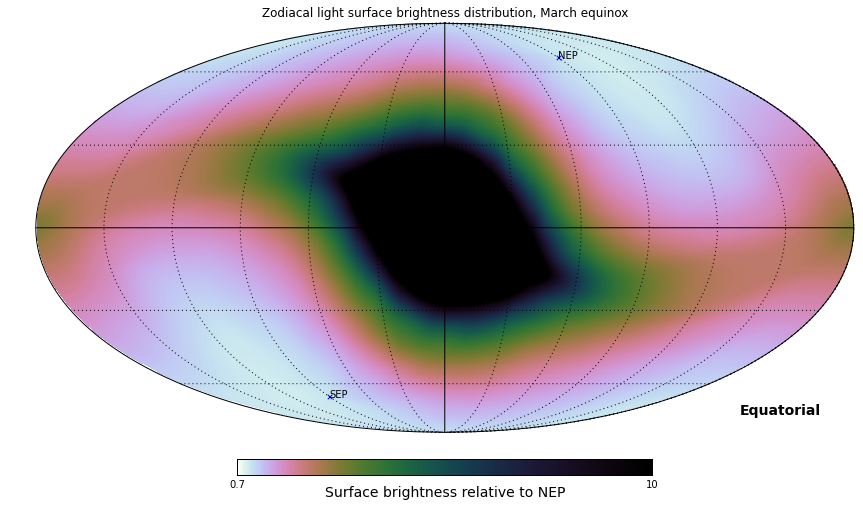

In [35]:
hp.mollview(zl_map, coord=('E', 'C'), cmap='cubehelix_r', min=0.7, max=10, norm='log', \
            title='Zodiacal light surface brightness distribution, March equinox', \
            unit='Surface brightness relative to NEP')
hp.graticule(coord='C', local=True)

hp.projscatter(0, 90, lonlat=True, marker='x', coord='E')
hp.projtext(0, 90, 'NEP', lonlat=True, coord='E')
hp.projscatter(0, -90, lonlat=True, marker='x', coord='E')
hp.projtext(0, -90, 'SEP', lonlat=True, coord='E')

plt.gcf().set_size_inches(12,7.5)
plt.savefig('ZL_March.png')

###Seasonal variations

The main effect is simply due to the movement of the Sun around the ecliptic equator over the course of the year.  As a result the distribution of zodiacal light on the sky rotates about an axis through the ecliptic poles.

In addition the zodiacal light exhibits seasonal variations due to the orbit of the Earth taking it above and below the symmetry plane of the zodiacal dust.  At high ecliptic latitudes this manifests as an approximately 10% sinusoidal variation in surface brightness.  For now we will ignore this.

Otherwise the zodiacal light is essentially time invariant. Resonant structures, comet tails and asteroid collisions result in variations of less than 1% and are largely confined to low ecliptic latitude.

In [36]:
# Very wasteful of RAM but for now just implement this using rotated copies of the ZL map

def map_rotate_polar(input_map, angle):
    '''
    Function to return a copy of a healpy map rotated about its polar axis
    '''
    npix = input_map.size
    nside = hp.npix2nside(npix)
    # Get coordinates of each pixel in original map
    indices = np.arange(npix)
    theta,phi = hp.pix2ang(nside, indices)
    # New empty map for rotated copy
    output_map = np.empty_like(input_map)
    # Rotator object to transform pixel coordinates
    rotator = hp.Rotator(deg=True, rot=[angle,0])
    # For each pixel in original map calculate new coordinates and copy
    # into appropriate pixel in new map.
    output_map[hp.ang2pix(nside, *rotator(theta, phi))] = input_map
    return output_map

In [37]:
zl_map_90 = map_rotate_polar(zl_map, 90)
zl_map_180 = map_rotate_polar(zl_map, 180)
zl_map_270 = map_rotate_polar(zl_map, 270)

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The inter

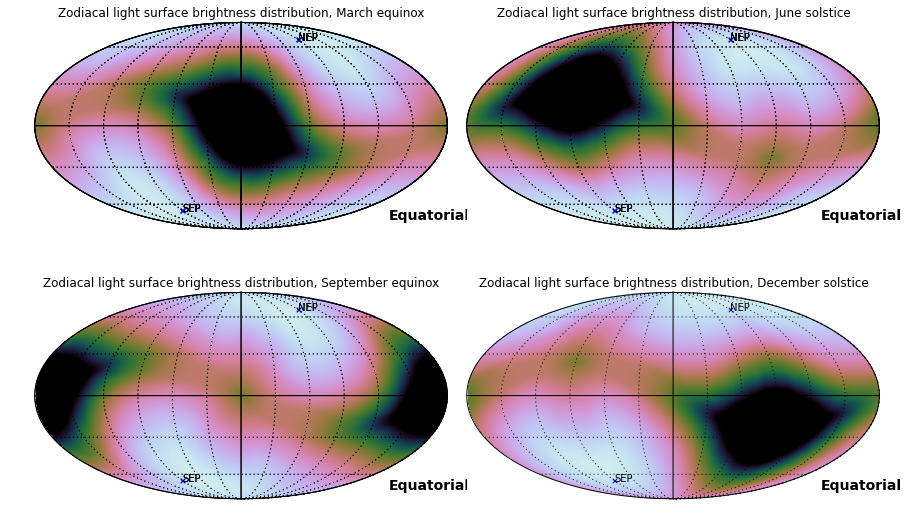

In [38]:
hp.mollview(zl_map, coord=('E', 'C'), cmap='cubehelix_r', min=0.7, max=10, \
            norm='log', sub=(2,2,1), cbar=False, \
            title='Zodiacal light surface brightness distribution, March equinox', \
            unit='Surface brightness relative to NEP')
hp.graticule(coord='C', local=True)
hp.projscatter(0, 90, lonlat=True, marker='x', coord='E')
hp.projtext(0, 90, 'NEP', lonlat=True, coord='E')
hp.projscatter(0, -90, lonlat=True, marker='x', coord='E')
hp.projtext(0, -90, 'SEP', lonlat=True, coord='E')

hp.mollview(zl_map_270, coord=('E', 'C'), cmap='cubehelix_r', min=0.7, max=10, \
            norm='log', sub=(2,2,2), cbar=False, \
            title='Zodiacal light surface brightness distribution, June solstice', \
            unit='Surface brightness relative to NEP')
hp.graticule(coord='C', local=True)
hp.projscatter(0, 90, lonlat=True, marker='x', coord='E')
hp.projtext(0, 90, 'NEP', lonlat=True, coord='E')
hp.projscatter(0, -90, lonlat=True, marker='x', coord='E')
hp.projtext(0, -90, 'SEP', lonlat=True, coord='E')

hp.mollview(zl_map_180, coord=('E', 'C'), cmap='cubehelix_r', min=0.7, max=10, \
            norm='log', sub=(2,2,3), cbar=False, \
            title='Zodiacal light surface brightness distribution, September equinox', \
            unit='Surface brightness relative to NEP')
hp.graticule(coord='C', local=True)
hp.projscatter(0, 90, lonlat=True, marker='x', coord='E')
hp.projtext(0, 90, 'NEP', lonlat=True, coord='E')
hp.projscatter(0, -90, lonlat=True, marker='x', coord='E')
hp.projtext(0, -90, 'SEP', lonlat=True, coord='E')

hp.mollview(zl_map_90, coord=('E', 'C'), cmap='cubehelix_r', min=0.7, max=10, \
            norm='log', sub=(2,2,4), cbar=False, \
            title='Zodiacal light surface brightness distribution, December solstice', \
            unit='Surface brightness relative to NEP')
hp.graticule(coord='C', local=True)
hp.projscatter(0, 90, lonlat=True, marker='x', coord='E')
hp.projtext(0, 90, 'NEP', lonlat=True, coord='E')
hp.projscatter(0, -90, lonlat=True, marker='x', coord='E')
hp.projtext(0, -90, 'SEP', lonlat=True, coord='E')

plt.gcf().set_size_inches(12,7.5)
plt.savefig('ZL_seasonal.png')

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The inter

/home/ajh/Documents/virtualenvs/sci-latest-python3.4.1/lib/python3.4/site-packages/healpy/projaxes.py:387: RuntimeWarning: invalid value encountered in greater
  w=np.where(d2 > threshold)[0]


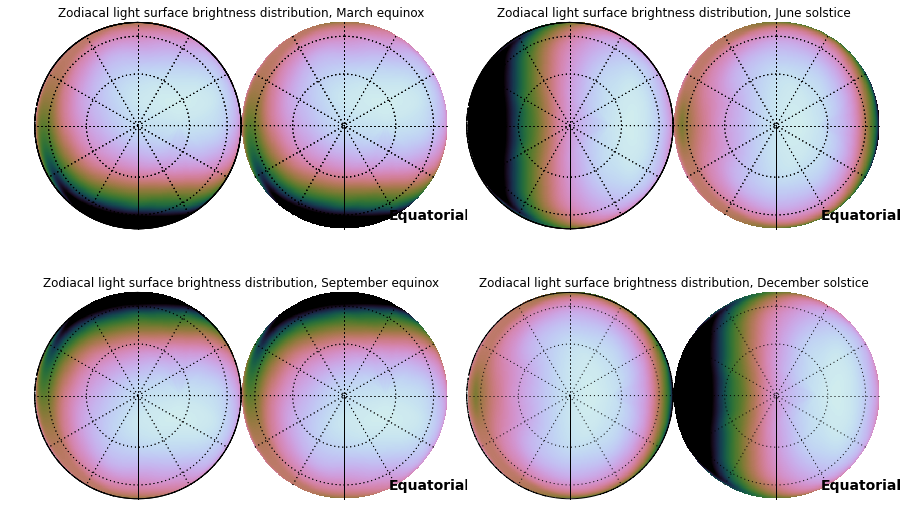

In [39]:
hp.orthview(zl_map, rot=(0,90), coord=('E', 'C'), cmap='cubehelix_r', min=0.7, max=10, \
            norm='log', sub=(2,2,1), cbar=False, \
            title='Zodiacal light surface brightness distribution, March equinox', \
            unit='Surface brightness relative to NEP')
hp.graticule(coord='C')

hp.orthview(zl_map_270, rot=(0,90), coord=('E', 'C'), cmap='cubehelix_r', min=0.7, max=10, \
            norm='log', sub=(2,2,2), cbar=False, \
            title='Zodiacal light surface brightness distribution, June solstice', \
            unit='Surface brightness relative to NEP')
hp.graticule(coord='C')

hp.orthview(zl_map_180, rot=(0,90), coord=('E', 'C'), cmap='cubehelix_r', min=0.7, max=10, \
            norm='log', sub=(2,2,3), cbar=False, \
            title='Zodiacal light surface brightness distribution, September equinox', \
            unit='Surface brightness relative to NEP')
hp.graticule(coord='C')

hp.orthview(zl_map_90, rot=(0,90), coord=('E', 'C'), cmap='cubehelix_r', min=0.7, max=10, \
            norm='log', sub=(2,2,4), cbar=False, \
            title='Zodiacal light surface brightness distribution, December solstice', \
            unit='Surface brightness relative to NEP')
hp.graticule(coord='C')

plt.gcf().set_size_inches(12,7.5)

# Instrumental Background

In order to obtain the highest sensitivity possible we want to be sky-noise limited, i.e. the total instrumental background should be significantly less than the detected sky background.

##Dark current

At visible wavelengths the dominant source of instrumental background will be the dark current of the image sensor.  Wang et al (2014), http://proceedings.spiedigitallibrary.org/proceeding.aspx?articleid=1891414, measured the dark current of an e2v CMOS image sensor prototype (CIS107) between 250 and 300 K and found that the dark current was well fit by
$D = 10^{0.0488T - 12.772}$ e$^-$ s$^{-1}$ pixel$^{-1}$, where $T$ is the temperature in Kelvin.  For our nominal operating temperature of -40$^\circ$C we get

In [40]:
T = (-40 * u.deg_C).to(u.K, equivalencies=u.temperature())
dark_current = 10**(0.0488 * T.value - 12.772) * u.electron * u.second**-1 * u.pixel**-1
dark_current

<Quantity 0.04033852370388624 electron / (pix s)>

# Background summary

Comparing the detected zodical light background with the image sensor dark current we see that, as desired, the sky background (zodical light) dominates over the instrument background (dark current) for all band except u, however the situation is somewhat marginal in z band.  If it proves practical operating the image sensor at slightly lower temperatures than -40$^\circ$C would be beneficial here.

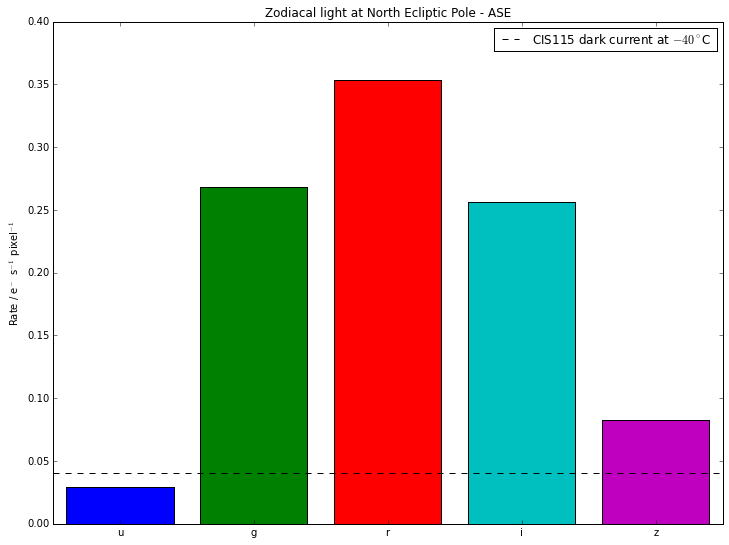

In [41]:
plt.bar([1,2,3,4,5],zl_ep.data, align='center', color=('b','g','r','c','m'))
plt.hlines(dark_current.value, 0.5, 5.5, linestyle='dashed', label='CIS115 dark current at $-40^\circ$C')
plt.xlim(0.5,5.5)
plt.legend(loc='best')
plt.xticks((1,2,3,4,5), ('u','g','r','i','z'))
plt.ylabel('Rate / e$^-$ s$^{-1}$ pixel$^{-1}$')
plt.title('Zodiacal light at North Ecliptic Pole - ASE')
plt.savefig('NEPbackground.png')

# Read noise & exposure time

In addition to the stochastic Poisson/shot noise associated with the source, sky and instrument background there is also noise associated with read out of the image sensor.  For the CIS115 image sensor Soman et al report a mean read noise of 4.25 e/pixel at room temperature and 5MHz pixel readout rate per output and a read noise of 5.6 e/pixel for the prototype CIS107 device.  Wang et al found that the read noise of the prototype CIS107 device reduced at low temperature and they measured a read noise of 4.0 e/pixel for 0.5 MHz readout rate at temperatures of 260 K and below.  For these calculations we will assume a read noise of 4.0 e/pixel. 

In [42]:
read_noise = 4 * u.electron / u.pixel

The impact of read noise on the sensitivity of the instrument depends on the length of the individual exposures used during observations.  We are primarily interesting in case of sources that are significantly fainter then the sky background (sky noise limited).  In this case sensisitivity, quantified in terms of the surface brightness at a given signal-to-noise ratio for a given total exposure time, can be written (approximately) as $S_{\rm{limit}} = \frac{\sigma}{\tau A \Omega \sqrt{t}} \sqrt{Z + D + R^2/t_{\rm{sub}}},$ where $\sigma$ is the signal-to-noise ratio target, $\tau$ is the end-to-end efficiency of the instrument, $A$ is the area of the aperture, $\Omega$ is the solid angle of sky used for the calculation (e.g. the solid angle subtended by a pixel), $t$ is the total exposure time, $Z$ is the detected sky background rate, $D$ is the dark current rate, $R$ is the read noise and $t_{\rm{sub}}$ is the length of an individual exposure (sub-exposure time).  In order to easily quantify the impact of read noise we can calculate the ratio of this limiting surface brightness to what it would be in the absence of read noise, i.e. $\sqrt{Z + D + R^2/t_{\rm{sub}}} / \sqrt{Z + D}$

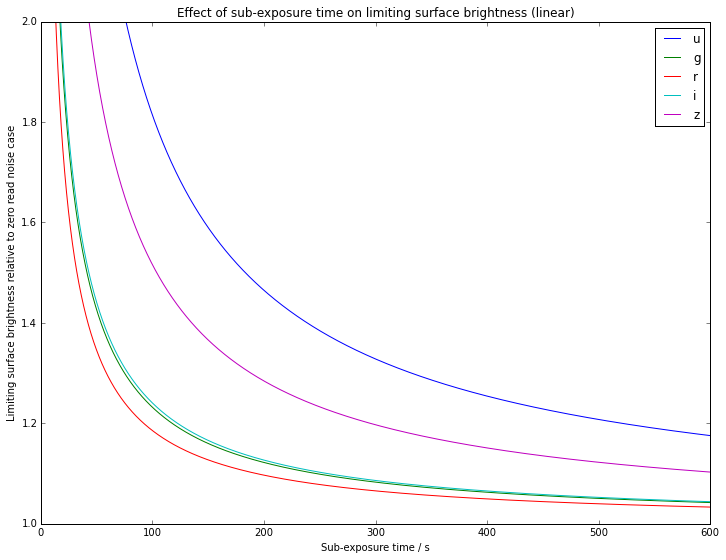

In [43]:
t_subs = np.arange(0.1, 601, 0.1) * u.second
bands = ['u','g','r','i','z']

for i, ZtAO in enumerate(zl_ep):
    S_lims = np.sqrt((ZtAO + dark_current) * u.electron / u.pixel + read_noise**2 / t_subs)
    S_lim0 = np.sqrt((ZtAO + dark_current) * u.electron / u.pixel)
    plt.plot(t_subs, S_lims/S_lim0, label=bands[i])

plt.xlim(0,600)
plt.ylim(1,2)
plt.legend(loc='best')
plt.xlabel('Sub-exposure time / s')
plt.ylabel('Limiting surface brightness relative to zero read noise case')
plt.title('Effect of sub-exposure time on limiting surface brightness (linear)')

From this plot we can see that with if, for example, we want to achieve sensitivity within 20% of what it would be in the absence of read noise then we would need i band sub-exposures to be at least 120 s and z band sub-exposures to be at least 300 s.  Individual exposure times of 600 s may be preferred in any case in order to keep the average data rate within the downlink capacity however this would have implications for the pointing stability requirements and will also result in a greater impact from cosmic rays.

# Extinction

##Dust reddening map

For observations of extragalactic targets we must consider extinction by interstellar dust.  All sky maps of dust reddening (E(B-V)) are available from the Planck Legacy Archive, the methodology used in described in "Planck 2013 results. XI. All-sky model of thermal dust emission", http://dx.doi.org/10.1051/0004-6361/201323195

In [44]:
EBV_map = hp.read_map('resources/HFI_CompMap_ThermalDustModel_2048_R1.20.fits', field=2)

NSIDE = 2048
ORDERING = NESTED in fits file
Ordering converted to RING


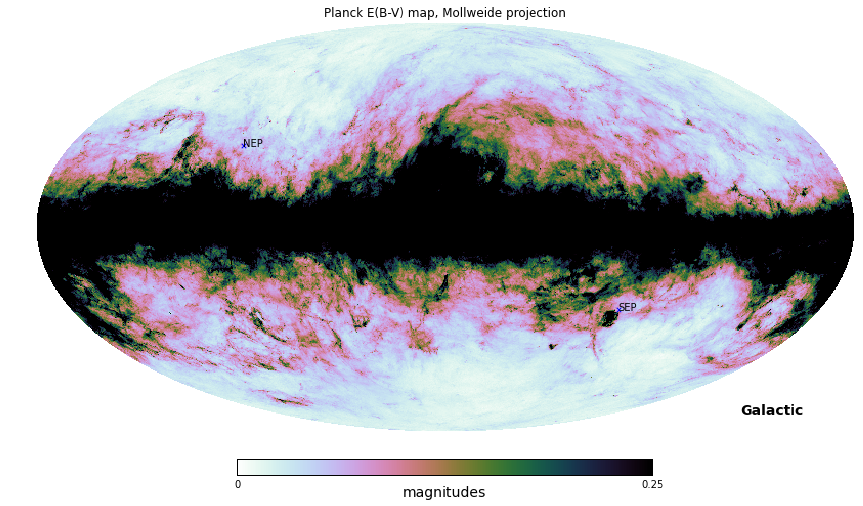

In [45]:
hp.mollview(EBV_map, min=0, max=0.25, coord=('G', 'G'), cmap='cubehelix_r', title='Planck E(B-V) map, Mollweide projection', unit='magnitudes')
hp.projscatter(0, 90, lonlat=True, marker='x', coord='E')
hp.projtext(0, 90, 'NEP', lonlat=True, coord='E')
hp.projscatter(0, -90, lonlat=True, marker='x', coord='E')
hp.projtext(0, -90, 'SEP', lonlat=True, coord='E')

plt.gcf().set_size_inches(12,7.5)

## Extinction law

To incorporate the effects of interstellar extinction into these calculations we must first convert these reddening data into extinction values using an extinction law.  Here we will use the prescription of Fitzpatrick (1999),  http://www.jstor.org/stable/10.1086/316293 with $R=3.1$.

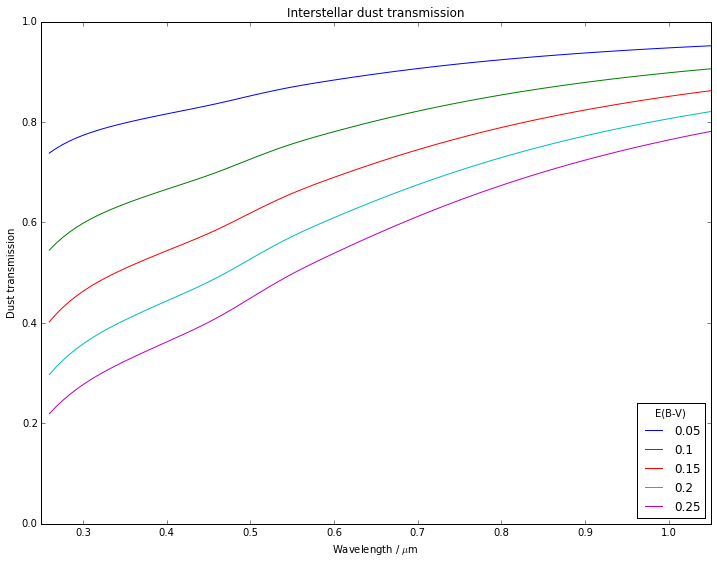

In [46]:
# Data
f99_waves = (np.Inf, 2.65, 1.22, 0.6, 0.547, 0.467, 0.411, 0.27, 0.26) * u.micron
f99_E_to_A = (0, 0.265, 0.829, 2.688, 3.055, 3.806, 4.315, 6.265, 6.591) * u.dimensionless_unscaled
# Cubic spline interpolation in inverse wavelength space
f99 = InterpolatedUnivariateSpline(1/f99_waves, f99_E_to_A, k=3, ext='raise')

def dust_transmission(E, wave):
    A = f99(1/wave) * E
    return 10**(-0.4*A)

waves = np.linspace(0.26,1.05,100) * u.micron
Es = [0.05, 0.1, 0.15, 0.20, 0.25]
for E in Es:
    plt.plot(waves, dust_transmission(E, waves), label=E)
plt.ylim(0,1)
plt.xlim(0.25,1.05)
plt.xlabel('Wavelength / $\mu$m')
plt.ylabel('Dust transmission')
plt.legend(loc=4, title='E(B-V)')
plt.title('Interstellar dust transmission')

## Pivot wavelengths

The pivot wavelength of a band is the effective wavelength to use when converting between $F_\lambda$ and $F_\nu$ units.  It is independant of the source spectrum.  We'll also use these when calculating the dust transmission.

In [47]:
pivot_waves = []

for i, f in enumerate(filters):
    # Interpolate efficiency data at same wavelengths as solar/zodiacal light data
    ieff =  np.interp(zl_waves, f['Wavelength'], efficiencies[i])
    # Integrate over wavelength
    p1 = np.trapz(ieff * zl_waves, x=zl_waves)
    p2 = np.trapz(ieff / zl_waves, x=zl_waves)
    pivot_waves.append(np.sqrt(p1/p2))
    
pivot_waves = u.Quantity(pivot_waves)
pivot_waves

<Quantity [ 0.36740525, 0.47121388, 0.63899447, 0.77395907, 0.90245854] micron>

## Dust transmission maps

We can use the extinction law to create dust transmission maps for each band.  For a quick look can just calculate the transmission value for the pivot wavelength of a band but for accurate work the source spectrum should be convolved with the dust transmission function.

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


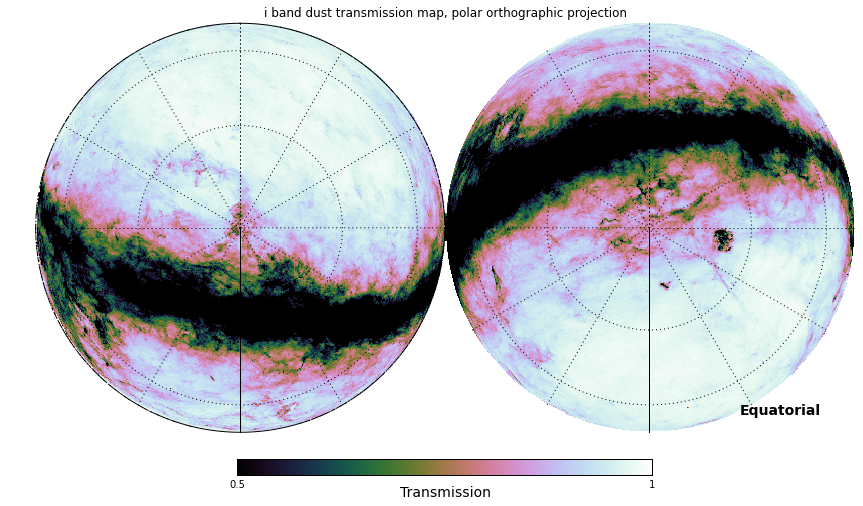

In [48]:
plt.cm.cubehelix.set_under('w')
hp.orthview(dust_transmission(EBV_map, pivot_waves[4]), rot=(0,90), min=0.5, max=1, coord=('G', 'C'), \
            cmap='cubehelix', title='i band dust transmission map, polar orthographic projection', unit='Transmission')
hp.graticule()
plt.gcf().set_size_inches(12,7.5)

0.0 56.36685429194645 -180.0 180.0
The interval between parallels is 15 deg -0.00'.
The interval between meridians is 15 deg -0.00'.
0.0 56.36685429194645 -180.0 180.0
The interval between parallels is 15 deg -0.00'.
The interval between meridians is 15 deg -0.00'.
123.63314570805355 180.0 -180.0 180.0
The interval between parallels is 15 deg -0.00'.
The interval between meridians is 15 deg -0.00'.


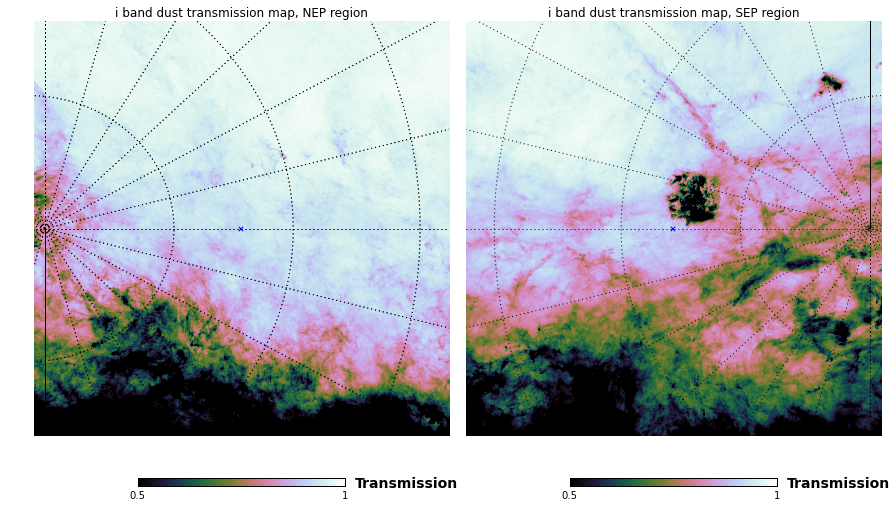

In [49]:
hp.gnomview(dust_transmission(EBV_map, pivot_waves[4]), xsize=2100, ysize=2100, \
            min=0.5, max=1, coord=('G', 'E'), rot=[0,90], \
            sub=(1,2,1), cmap='cubehelix', title='i band dust transmission map, NEP region', \
            unit='Transmission',notext=True)
hp.graticule(coord='C', local=False, dpar=15, dmer=15)
hp.projscatter(0, 90, lonlat=True, coord='E', marker='x')
hp.gnomview(dust_transmission(EBV_map, pivot_waves[3]), xsize=2100, ysize=2100, \
            min=0.5, max=1, coord=('G', 'E'), rot=[0,-90], \
            sub=(1,2,2), cmap='cubehelix', title='i band dust transmission map, SEP region', \
            unit='Transmission', notext=True)
hp.graticule(coord='C', local=False, dpar=15, dmer=15)
hp.projscatter(0, -90, lonlat=True, marker='x', coord='E')
plt.gcf().set_size_inches(12,7.5)
plt.savefig('dust_ecliptic_gnomic.png')

# Sensitivity

Let us write the surface brightness of the source that we wish to detect in terms of energy flux per unit solid angle per unit wavelength, $F_\lambda$.  We can write this as a produce of the photon weighted mean surface brightness and a normalised function which incorporated the wavelength dependance, i.e. $F_\lambda = F_0 f(\lambda)$ where $f(\lambda$ is normalised using $\int f(\lambda) \frac{\lambda}{\rm{hc}} \tau \rm{d}\lambda / \int \frac{\lambda}{\rm{hc}} \tau \rm{d}\lambda = 1$.

The signal rate (number of electrons per pixel per second) in the image sensor, $S = F_0 \int f(\lambda) \frac{\lambda}{\rm{hc}} \tau A \Omega  \rm{d}\lambda $ where $t$ is the total exposure time, $\tau$ is the end-to-end efficiency of the instrument (which may include dust extinction) in electrons per photon, $A$ is the area of the aperture and $\Omega$ is the solid angle of sky subtended by a pixel. 

The corresponding noise per pixel is given by $N = \sqrt{St + Zt + Dt + R^2t/t_{\mathrm{sub}}}$ where $Z$ is the detected sky background rate, $D$ is the dark current rate, $R$ is the read noise and $t_{\rm{sub}}$ is the length of an individual exposure (sub-exposure time).

The resulting signal to noise ratio, $\sigma = St/N = \frac{F_0 \sqrt{t} \int f(\lambda) \frac{\lambda}{\rm{hc}} \tau A \Omega  \rm{d}\lambda }{\sqrt{S + Z + D + R^2/t_{\mathrm{sub}}}} \approx \frac{F_0 \sqrt{t} \int f(\lambda) \frac{\lambda}{\rm{hc}} \tau A \Omega  \rm{d}\lambda }{\sqrt{Z + D + R^2/t_{\mathrm{sub}}}}$, where the approximation follows from the assumption that $S \ll Z + D + R^2/t_{\mathrm{sub}}$, i.e. the source is much fainter than the background.  This will generally be the case for scientifically interesting targets.

Rearranging we can obtain an expression for sensivity in terms of the limiting surface brightness which results in a given signal to noise ratio in a given total exposure time, $F_0 = \frac{\sigma}{\sqrt{t}}\frac{\sqrt{Z + D + R^2/t_{\mathrm{sub}}}}{\int f(\lambda) \frac{\lambda}{\rm{hc}} \tau A \Omega  \rm{d}\lambda}$.

Most of the terms of the right of this expression have already been calculated however we need to calculate the $\int f(\lambda) \frac{\lambda}{\rm{hc}} \tau A \Omega  \rm{d}\lambda$ factors for the instrument using representative source spectra $f(\lambda)$.  We already have a solar spectrum so for now will just use that.

## Average flux to electron rate factors

In [50]:
# Convert solar spectrum to photon flux per unit wavelength
solar_pfpw = sun_flux.to(u.Watt * u.m**-2 * u.micron**-1) / photon_energies
solar_pfpw = solar_pfpw.to(u.photon * u.second**-1 * u.m**-2 *  u.micron**-1)

solar_cr = []

for i, f in enumerate(filters):
    # Interpolate etendue data at same wavelengths as solar/zodiacal light data
    eff_etendue =  np.interp(zl_waves, f['Wavelength'], eff_etendues[i]) * \
        eff_etendues[i].unit
    # Multiply by effective etendue
    solar_crpw = solar_pfpw * eff_etendue
    #Integrate over wavelength
    solar_cr.append(np.trapz(solar_crpw, x=zl_waves))

# This is the e/s/pixel that would result from focussing the entire output of the sun onto one pixel (!)
solar_cr = u.Quantity(solar_cr)

# Need to normalise these with photon-weighted average solar fluxes over the filter bandpasses.
solar_flux = []

for i, f in enumerate(filters):
    # Interpolate filter data at same wavelengths as solar/zodiacal light data
    ieff =  np.interp(zl_waves, f['Wavelength'], efficiencies[i])
    # Multiply by normalised filter
    solar_efpw = solar_pfpw * ieff
    #Integrate over wavelength
    solar_flux.append(np.trapz(solar_efpw, x=zl_waves) / \
                      np.trapz(ieff/photon_energies, x=zl_waves))

solar_flux = u.Quantity(solar_flux)

flux_to_cr = solar_cr / solar_flux
flux_to_cr = flux_to_cr.to((u.electron * u.pixel**-1 * u.second**-1) / \
                           (u.Watt * u.arcsec**-2 * u.m**-2 * u.micron**-1))
print(flux_to_cr)

[  4.00576073e+15   1.57327169e+16   2.04493666e+16   1.85056594e+16
   7.60891863e+15] arcsec2 electron m2 micron / (pix s W)


## Noise equivalent backgrounds, on-sky equivalents

We can use these flux to count rate factors ($\int f(\lambda) \frac{\lambda}{\rm{hc}} \tau A \Omega  \rm{d}\lambda$) to calculate the on-sky surface brightness equivalent to the noise equivalent background, $Z + D + R^2/t_{\mathrm{sub}}$

In [51]:
t_sub = (600 * u.second * u.electron * u.pixel**-1) # Strange units so R^2/t_sub ends up in electrons / s.
neb600 = zl_ep + dark_current + read_noise**2 / t_sub
neb600

<Quantity [ 0.09645498, 0.33531587, 0.42055871, 0.32312641, 0.14976399] electron / (pix s)>

/home/ajh/Documents/virtualenvs/sci-latest-python3.4.1/lib/python3.4/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


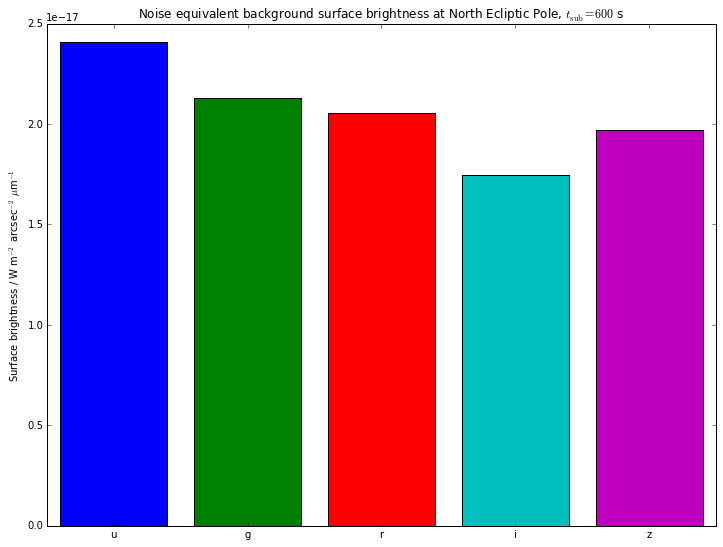

In [52]:
nes600 = neb600 / flux_to_cr

plt.bar([1,2,3,4,5],nes600.data, align='center', color=('b','g','r','c','m'))
plt.xlim(0.5,5.5)
plt.legend(loc='best')
plt.xticks((1,2,3,4,5), ('u','g','r','i','z'))
plt.ylabel('Surface brightness / W m$^{-2}$ arcsec$^{-2}$ $\mu$m$^{-1}$')
plt.title('Noise equivalent background surface brightness at North Ecliptic Pole, $t_{\mathrm{sub}}=600$ s')
plt.savefig('NEPbackground.png')

## Sensitivity limit

We can now calculate the sensitivity limits for the best case, low zodical light (using the ecliptic pole value) and no extinction.  In spectral flux density per unit wavelength per unit solid angle:

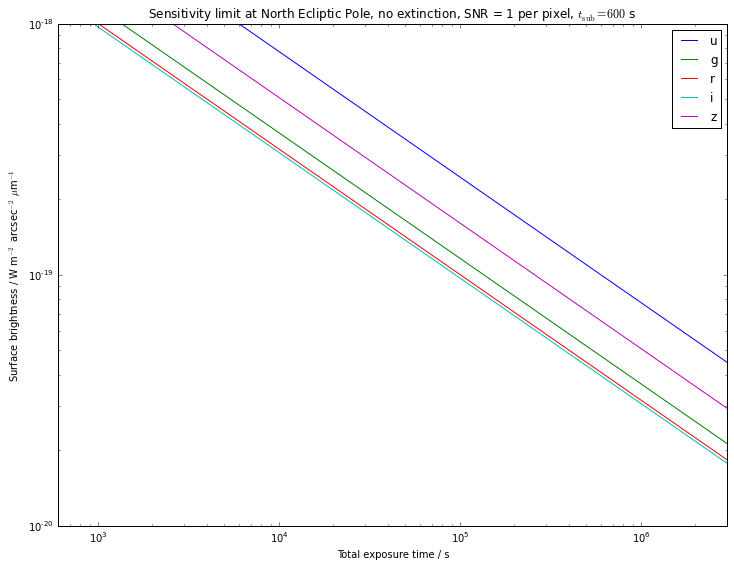

In [53]:
sigma = 1.0
def sb_limit(t, i):
    return sigma * np.sqrt(neb600[i]) * (u.electron/u.pixel)**0.5 / (np.sqrt(t) * flux_to_cr[i])

ts = [10**e for e in [2.5,3,3.5,4.5,5,5.5,6,6.5]] * u.second

sb_limits = []

for i, band in enumerate(bands):
    sb_limits.append(sb_limit(ts, i))
    
for i, band in enumerate(bands):    
    plt.loglog(ts,sb_limits[i], label=band)

plt.xlim(600,3000000)
plt.ylim(1e-20,1e-18)
plt.xlabel('Total exposure time / s')
plt.ylabel('Surface brightness / W m$^{-2}$ arcsec$^{-2}$ $\mu$m$^{-1}$')
plt.legend(loc='best')
plt.title('Sensitivity limit at North Ecliptic Pole, no extinction, SNR = 1 per pixel, $t_{\mathrm{sub}}=600$ s')

plt.savefig('sens_proper.png')
plt.savefig('sens_proper.pdf')

Now in magnitudes.  Must first convert spectral flux density per unit wavelength to Janskys, then to magnitudes.

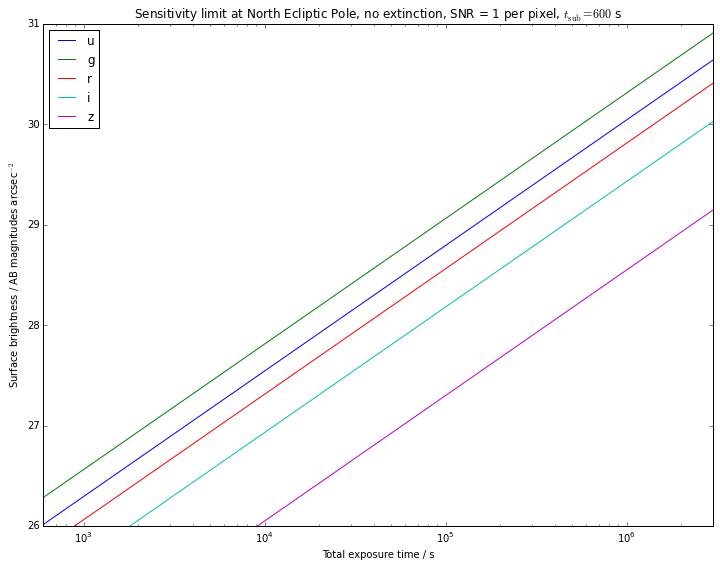

In [54]:
zero_point = 3631 * u.Jy
sb_limits_mag=[]
for i, band in enumerate(bands):
    sb_limits_Jy = (sb_limits[i] * u.arcsecond**2).to(u.Jy, equivalencies=u.spectral_density(pivot_waves[i]))
    sb_limits_mag.append(-2.5 * np.log10(sb_limits_Jy / zero_point))

for i, band in enumerate(bands):    
    plt.semilogx(ts,sb_limits_mag[i], label=band)    

plt.xlim(600,3000000)
plt.ylim(26,31)
plt.xlabel('Total exposure time / s')
plt.ylabel('Surface brightness / AB magnitudes arcsec$^{-2}$')
plt.legend(loc='best')
plt.title('Sensitivity limit at North Ecliptic Pole, no extinction, SNR = 1 per pixel, $t_{\mathrm{sub}}=600$ s')

plt.savefig('sens_mag.png')
plt.savefig('sens_mag.pdf')

##Sensitivity maps

Using the maps of zodical light distribution and dust transmision we can produce maps showing how sensitivity depends on sky position and thereby determine best target areas.

For maximum accuracy we should technically redo the entire calculcation for every position as the vary wavelength dependance of the dust transmission will alter the source spectrum which will in turn alter the average flux to count rate factors.  We are, however, only interested in regions with low extinction so the effect will be small, especially in the i and z bands where the dust transmission function is fairly flat.  Furthermore we are currently using a solar spectrum which is probably not a very good proxy for our actual targets anyway.  For these calculation we will simply scale the sensitivity using the dust transmission at the pivot wavelength for each band.

0.0 56.36685429194645 -180.0 180.0
The interval between parallels is 15 deg -0.00'.
The interval between meridians is 15 deg -0.00'.
0.0 56.36685429194645 -180.0 180.0
The interval between parallels is 15 deg -0.00'.
The interval between meridians is 15 deg -0.00'.
0.0 56.36685429194645 -180.0 180.0
The interval between parallels is 15 deg -0.00'.
The interval between meridians is 15 deg -0.00'.
0.0 56.36685429194645 -180.0 180.0
The interval between parallels is 15 deg -0.00'.
The interval between meridians is 15 deg -0.00'.
0.0 56.36685429194645 -180.0 180.0
The interval between parallels is 15 deg -0.00'.
The interval between meridians is 15 deg -0.00'.
123.63314570805355 180.0 -180.0 180.0
The interval between parallels is 15 deg -0.00'.
The interval between meridians is 15 deg -0.00'.
123.63314570805355 180.0 -180.0 180.0
The interval between parallels is 15 deg -0.00'.
The interval between meridians is 15 deg -0.00'.
123.63314570805355 180.0 -180.0 180.0
The interval between para

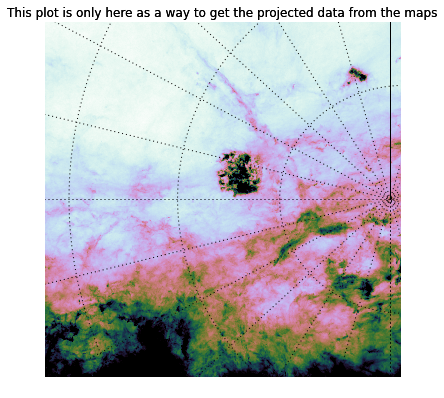

In [55]:
zl_nep_March = hp.gnomview(zl_map, fig=0, xsize=2100, ysize=2100, cbar=None, \
            min=0.7, max=4, coord=('E', 'E'), rot=[0,90], \
            cmap='cubehelix_r', title='', \
            unit='ZL',notext=True, return_projected_map=True)
zl_nep_June = hp.gnomview(zl_map_270, fig=0, xsize=2100, ysize=2100, cbar=None, \
            min=0.7, max=4, coord=('E', 'E'), rot=[0,90], \
            cmap='cubehelix_r', title='', \
            unit='ZL',notext=True, return_projected_map=True)
zl_nep_September = hp.gnomview(zl_map_180, fig=0, xsize=2100, ysize=2100, cbar=None, \
            min=0.7, max=4, coord=('E', 'E'), rot=[0,90], \
            cmap='cubehelix_r', title='', \
            unit='ZL',notext=True, return_projected_map=True)
zl_nep_December = hp.gnomview(zl_map_90, fig=0, xsize=2100, ysize=2100, cbar=None, \
            min=0.7, max=4, coord=('E', 'E'), rot=[0,90], \
            cmap='cubehelix_r', title='', \
            unit='ZL',notext=True, return_projected_map=True)
trans_nep_z = hp.gnomview(dust_transmission(EBV_map, pivot_waves[4]), xsize=2100, ysize=2100, fig=0, \
            min=0.5, max=1, coord=('G', 'E'), rot=[0,90], \
            cmap='cubehelix', title='This plot is only here as a way to get the projected data from the maps', cbar=None, \
            unit='Transmission', notext=True, return_projected_map=True)

zl_sep_March = hp.gnomview(zl_map, fig=0, xsize=2100, ysize=2100, cbar=None, \
            min=0.7, max=4, coord=('E', 'E'), rot=[0,-90], \
            cmap='cubehelix_r', title='', \
            unit='ZL',notext=True, return_projected_map=True)
zl_sep_June = hp.gnomview(zl_map_270, fig=0, xsize=2100, ysize=2100, cbar=None, \
            min=0.7, max=4, coord=('E', 'E'), rot=[0,-90], \
            cmap='cubehelix_r', title='', \
            unit='ZL',notext=True, return_projected_map=True)
zl_sep_September = hp.gnomview(zl_map_180, fig=0, xsize=2100, ysize=2100, cbar=None, \
            min=0.7, max=4, coord=('E', 'E'), rot=[0,-90], \
            cmap='cubehelix_r', title='', \
            unit='ZL',notext=True, return_projected_map=True)
zl_sep_December = hp.gnomview(zl_map_90, fig=0, xsize=2100, ysize=2100, cbar=None, \
            min=0.7, max=4, coord=('E', 'E'), rot=[0,-90], \
            cmap='cubehelix_r', title='', \
            unit='ZL',notext=True, return_projected_map=True)
trans_sep_z = hp.gnomview(dust_transmission(EBV_map, pivot_waves[4]), xsize=2100, ysize=2100, fig=0, \
            min=0.5, max=1, coord=('G', 'E'), rot=[0,-90], \
            cmap='cubehelix', title='This plot is only here as a way to get the projected data from the maps', cbar=None, \
            unit='Transmission', notext=True, return_projected_map=True)

hp.graticule(coord='C', local=False, dpar=15, dmer=15)
hp.projscatter(0, 90, lonlat=True, coord='E', marker='x');

In [56]:
def rel_sensitivity(zl_scale, trans, band):
    noise = np.sqrt(zl_scale * zl_ep[band] + dark_current + read_noise**2 / t_sub)
    noise_0 = np.sqrt(zl_ep[band] + dark_current + read_noise**2 / t_sub)
    return (noise/noise_0) / trans

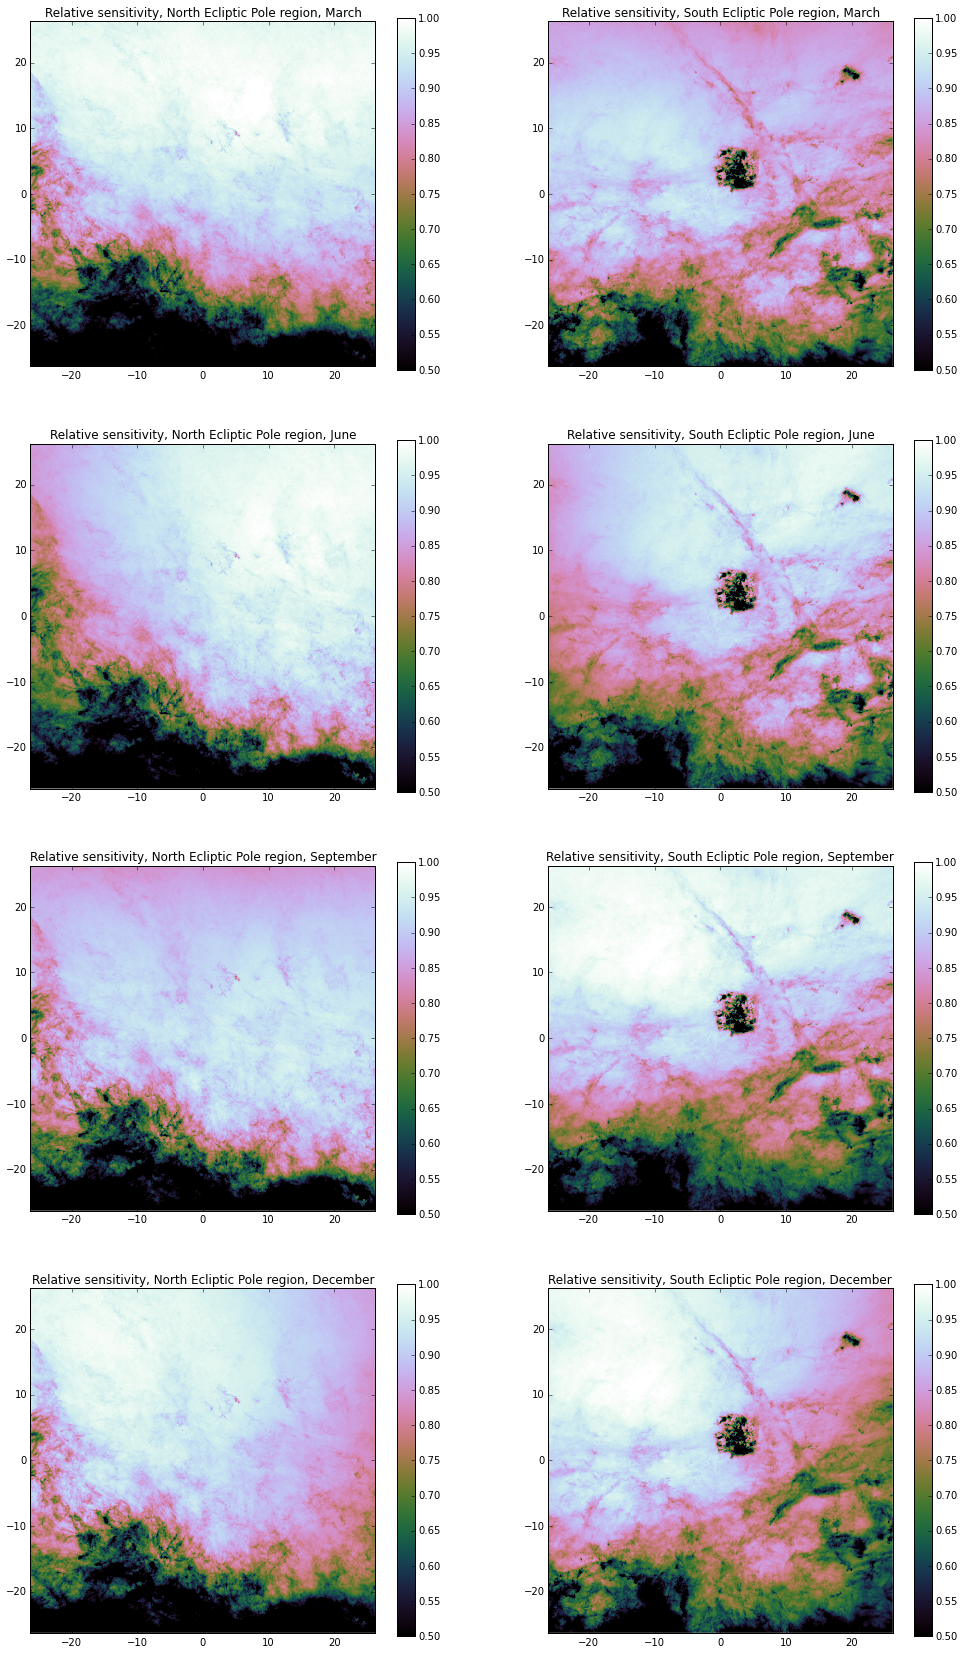

In [57]:
plt.cm.cubehelix.set_under('k')

zl_scales = [zl_nep_March, zl_sep_March, \
             zl_nep_June, zl_sep_June, \
             zl_nep_September, zl_sep_September,\
             zl_nep_December, zl_sep_December]

trans_zs = [trans_nep_z, trans_sep_z, \
            trans_nep_z, trans_sep_z, \
            trans_nep_z, trans_sep_z, \
            trans_nep_z, trans_sep_z,
            trans_nep_z, trans_sep_z] 

titles = ['Relative sensitivity, North Ecliptic Pole region, March', 'Relative sensitivity, South Ecliptic Pole region, March',\
          'Relative sensitivity, North Ecliptic Pole region, June', 'Relative sensitivity, South Ecliptic Pole region, June',\
          'Relative sensitivity, North Ecliptic Pole region, September', 'Relative sensitivity, South Ecliptic Pole region, September', \
          'Relative sensitivity, North Ecliptic Pole region, December', 'Relative sensitivity, South Ecliptic Pole region, December']

fig, axes = plt.subplots(nrows=4, ncols=2)

for i, ax in enumerate(axes.flat):
    im = ax.imshow(1/rel_sensitivity(zl_scales[i], trans_zs[i], band=4), \
                   cmap='cubehelix', interpolation='none', origin='lower',\
                   vmin=0.5, vmax=1, extent=[-26.25,26.25,-26.25,26.25])
    fig.colorbar(im, ax=ax)
    ax.set_title(titles[i])
    
plt.gcf().set_size_inches(17,29)
plt.savefig('Rel_sens_z_maps.png')
plt.savefig('Rel_sens_z_maps.pdf')